# Spiking BG Model 1

## 2015-06-19

I have my "first draft" neuron models for STN, GPe and SNr and have pulled in the D1 and D2 MSN models from Dave B.

I've been thinking about the receptors in SNr, GPe and STN.

### GPe receptors

There are GABA receptors in GPe, activated by projections from Striatum. Cannabinoid receptors modulate the effect of the GABA receptors - stimulation of the cannabinoid receptors reduces uptake of GABA. See Di Marzo et al, "Enhanced levels of endogenous cannabinoids..." FASEB Vol 14, 2000.

## 2015-06-22
More on receptors. Will make use of single exponential model for synapses, as used in Humphries et al, Front. Comp. Neurosci. 2009. These are coded up with the following parameters:

<table>
<tr><th>Parameters</th><th>Description</th></tr>
<tr><td>tau_gaba</td><td>Time constant</td></tr>
<tr><td>E_gaba</td><td>reversal potential</td></tr>
<tr><td>g_gaba</td><td>conductance</td></tr>
<tr><td>N_gaba</td><td>number of (receptors? spikes?)</td></tr>
</table>

Similar for AMPA, and also for NMDA, but NMDA also has voltage dependent Mg blocking.

Here are the values used in Dave B's Substance P microstriatal model (taken from Humphries 2009? Can't find the numbers in there):
.
<table>
<tr><th>Postsynapse</th>    <th>tau</th>    <th>E</th> <th>g</th>      <th>N</th> <th>Mg ion</th></tr>
<tr><td>D1 input, AMPA</td> <td>6 ms</td>   <td>0</td> <td>0.4 nS</td> <td>2000</td> <td>&nbsp;</td></tr>
<tr><td>D1 input, NMDA</td> <td>160 ms</td> <td>0</td> <td>0.2 nS</td> <td>600</td> <td>1 mmol</td></tr>
<tr><td>FSI->D2 MSN, GABA</td> <td>4 ms</td> <td>-60</td> <td>3.75 nS</td> <td>2000</td> <td>&nbsp;</td></tr>
<tr><td>FSI recurrent, GABA</td> <td>4 ms</td> <td>-60</td> <td>1.1 nS</td> <td>2000</td> <td>&nbsp;</td></tr>
<tr><td>FSI input, AMPA</td> <td>6 ms</td>   <td>0</td> <td>1 nS</td> <td>2000</td> <td>&nbsp;</td></tr>
<tr><td>D2 MSN->D1 MSN, GABA</td> <td>4 ms</td>   <td>-60</td> <td>0.75 nS</td> <td>2000</td> <td>&nbsp;</td></tr>
</table>

## 2015-06-22
Dave Buxton replied to me with details of the source of the tables above; it's Tomkins et al. "Transient and steady-state selection in the striatal microcircuit"

## 2015-06-24
Yesterday, I got the spiking model running, with 60 neurons per population; see bg1. I also made a much-scaled down version with only 6 neurons per population in it.

One thing I noticed, and it's something Alex B noticed in his Masters Thesis, is that the NMDA currents go sharply negative due to their membrane voltage dependence. It's not clear that this is going to make a significant difference to the behaviour of the neuron, but it's worth examining this.

I therefore made an update to the NMDA postsynapse which follows Tomkins et al., adding a v_syn state variable which obeys a first order diff. eqn. as follows:

$$\dot{v}_{syn} = {-v_{syn}+v\over \tau_{syn}}$$

where $v$ is the membrane voltage at the soma, $v_{syn}$ is the membrane voltage at the postsynapse on the dendrite and $\tau_{syn}$ is the time constant for the smoothing of the synaptic currents.

## 2015-06-25
I've built a SpineML model to explore the effect of the above, comparing smoothed and unsmoothed versions of the AMPA and NMDA synapses.

Let's run that here and have a look at the results.

In [38]:
# Run Izhi_STN_IV
def run_synsmooth_model (expt=0, tau_syn=1):

    import sys
    sys.path.append("../analysis")
    
    # This model/expt runs for 3 seconds. First second is the unsmoothed synapses,
    # last second is the smoothed synapses. In each case, 10 spike trains deliver 5 s/s
    # each. Vary tau_syn to see how the synaptic currents and the firing rate changes.
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/synapse_smoothing';
    population = 'STN'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';
 
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -pSmooth\\ Exciting\\ to\\ STN\\ Synapse\\ 0\\ postsynapse:tau_syn:'+\
                 `tau_syn`+' -pSmooth\\ Exciting\\ to\\ STN\\ Synapse\\ 1\\ postsynapse:tau_syn:'+\
                 `tau_syn`+'; popd"';
    os.system(spinemlcmd);

    # load the data from the model run.
    import load_sc_data as lsd
    # The membrane voltage:
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    # And all the synaptic currents:
    ampa, ampa_count, ta, nna, dta = lsd.load_sc_data (spinemltmp+'Exciting_to_STN_Synapse_0_postsynapse_I_ampa_log.bin');
    ampa_exciting, ampae_count, tae, nnae, dtae = lsd.load_sc_data (spinemltmp+'Smooth_Exciting_to_STN_Synapse_0_postsynapse_I_ampa_log.bin');
    nmda, nmda_count, tn, nnn, dtn = lsd.load_sc_data (spinemltmp+'Exciting_to_STN_Synapse_1_postsynapse_I_nmda_log.bin');
    nmda_exciting, nmdae_count, tne, nne, dte = lsd.load_sc_data (spinemltmp+'Smooth_Exciting_to_STN_Synapse_1_postsynapse_I_nmda_log.bin');
    i, i_count, ti, nni, dti = lsd.load_sc_data (spinemltmp+population+'_I_log.bin');
            
    # Plot data
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    
    r1s = 2000; r1e = 9999;
    r2s = 22000; r2e = 29999;

    # Do some analysis on the firing rates from 200-1000 ms and from 2200-3000 ms for comparison.
    import firing_rate as fr
    rate, isiRate = fr.firing_rate (v[r1s:r1e], t[r1e-r1s], 0.1)
    print 'Unsmoothed rate:', rate, ' isiRate:', isiRate

    rate, isiRate = fr.firing_rate (v[r2s:r2e], t[r2e-r2s], 0.1)
    print 'Smoothed rate:', rate, ' isiRate:', isiRate

    
    # Smoothed.
    fig = plt.figure(figsize=(18,10))
    plt.clf
    
    plt.subplot(2, 1, 1)
    plt.plot(t[r2s:r2e], v[r2s:r2e], 'k')
    plt.title('Smoothed synapses. Membrane voltage')
    plt.xlabel('t (ms)')
    plt.ylabel('v')

    ax1 = plt.subplot(2, 1, 2)
    ax1.plot(t[r2s:r2e], nmda_exciting[r2s:r2e], 'r')
    ax1.set_title('Smoothed AMPA and NMDA synapsic currents')
    ax1.set_xlabel('t (ms)')
    ax1.set_ylabel('I NMDA (pA)', color='r')
    ax1.set_ylim([-20,120])

    ax2 = ax1.twinx()
    ax2.plot(t[r2s:r2e], ampa_exciting[r2s:r2e], 'b')
    ax2.set_ylabel('I AMPA (pA)', color='b')
    ax2.set_ylim([-20,120])

    ax3 = fig.add_axes([0.74, 0.37, 0.15, 0.1])
    ax3.plot(t[23600:24000], ampa_exciting[23600:24000], 'b')
    ax3.set_xlabel('t (ms)')
    ax3.set_ylabel('I AMPA (pA)', color='b')
    #ax3.xaxis.set_major_locator(ticker.NullLocator)
    for tick in ax3.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_fontsize(1)
        tick.label1.set_horizontalalignment('center')
    
    ax4 = fig.add_axes([0.54, 0.37, 0.15, 0.1])
    ax4.plot(t[23600:24000], nmda_exciting[23600:24000], 'r')
    ax4.set_xlabel('t (ms)')
    ax4.set_ylabel('I NMDA (pA)', color='r')
    
    # Unsmoothed
    plt.figure(figsize=(18,10))
    plt.clf;
    
    plt.subplot(2, 1, 1)
    plt.plot(t[r1s:r1e], v[r1s:r1e], 'k')
    plt.title('Unsmoothed synapses. Membrane voltage')
    plt.xlabel('t (ms)')
    plt.ylabel('v')

    ax1 = plt.subplot(2, 1, 2)
    ax1.plot(t[r1s:r1e], nmda[r1s:r1e], 'r')
    ax1.set_title('Unsmoothed AMPA and NMDA synapsic currents')
    ax1.set_xlabel('t (ms)')
    ax1.set_ylabel('I NMDA (pA)', color='r')

    ax2 = ax1.twinx()
    ax2.plot(t[r1s:r1e], ampa[r1s:r1e], 'b')
    ax2.set_ylabel('I AMPA (pA)', color='b')
    
    # Need to call: from bokeh.plotting import figure, output_notebook, show as bokshow
    #output_notebook()
    #p = figure()
    #p.line(t,v, line_width=1)
    #show(p)
    # Abortive attempt:
    #q = figure()
    #q.line(t,ampa_exciting, line_width=2)
    #s = gridplot([p, q])
    #show(s)

Unsmoothed rate: 126.265783223  isiRate: 128.091312619
Smoothed rate: 136.267033379  isiRate: 138.465447154


<function __main__.run_synsmooth_model>

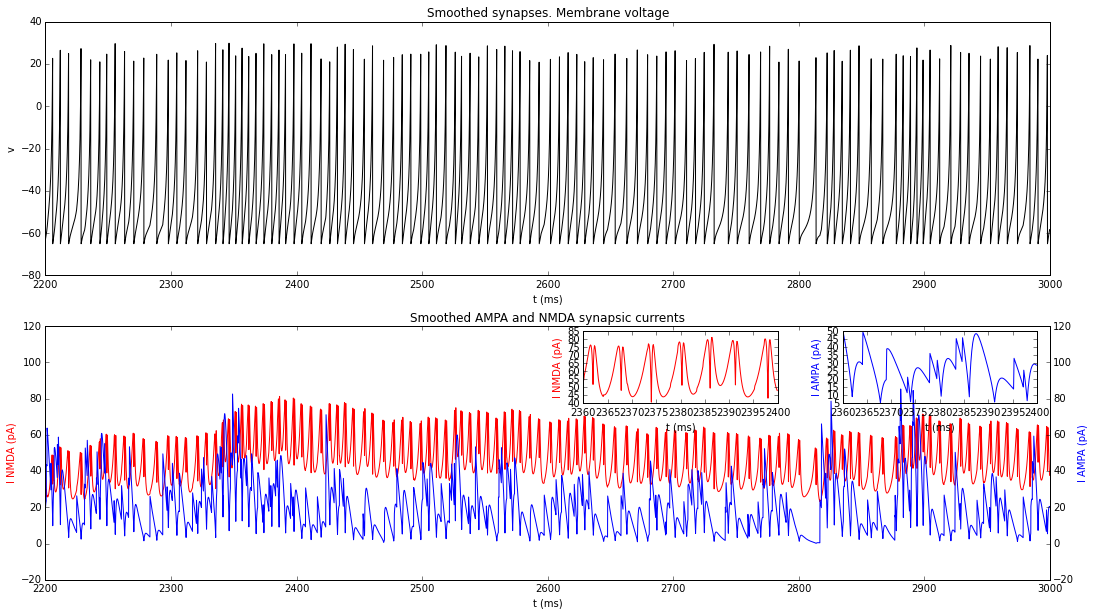

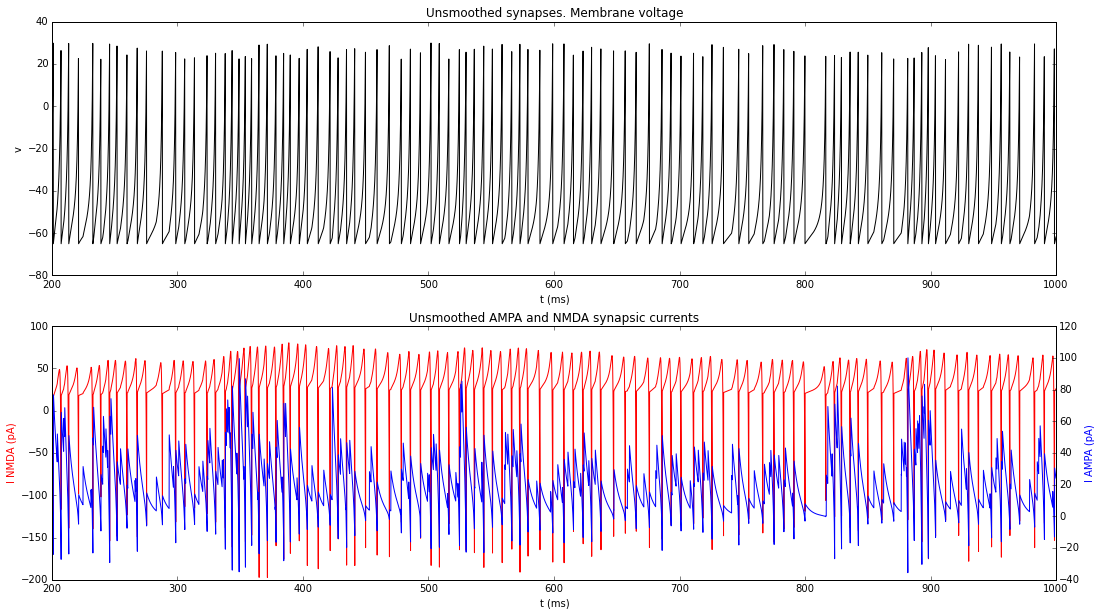

In [39]:
from bokeh.io import gridplot, output_notebook, show
from bokeh.plotting import figure
from IPython.html.widgets import interact

interact(run_synsmooth_model, expt=(0,10,1), tau_syn=(0.2,100,0.2))

### Conclusion from the above
Using the action potential directly to generate the synaptic currents does cause some slightly odd looking negative currents in NMDA, but this has minimal overall effect on the firing rate of the neuron, especially in a near tonic region. The effect increases as the synaptic input rate increases. To explore. change the currents in the experiment.

## Alternative graphing systems
matplotlib isn't interactive - it'd be nicer to have graphs which allow me to zoom and pan. Bokeh and Plotly are candidates for this.


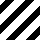
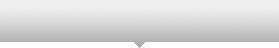
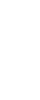
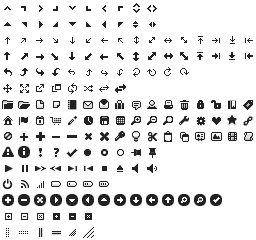
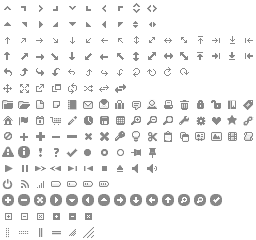
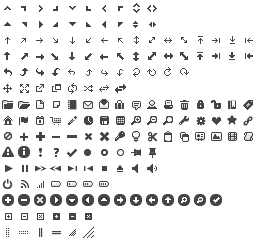
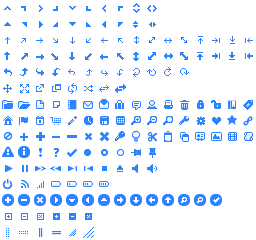
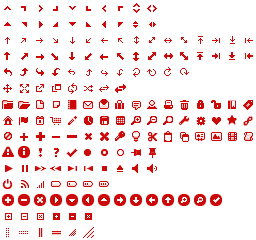
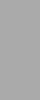
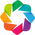
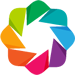
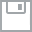
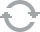
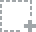
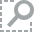
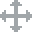
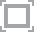
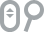

In [40]:
# Testing bokeh
from bokeh.plotting import figure, output_notebook, show as bokshow
output_notebook()
p = figure()
p.line([1,2,3],[3,3,2], line_width=1)
bokshow(p)

## 2015-06-26
I'm now happy about the synapses. I think the circa 15% difference in spiking rate which the smoothing can make is somewhat significant. However, I've not yet looked into the issue of active dendritic currents. Will discuss this with Nico.

### Back to the spiking model
The next issue is about scaling the input within the BG model. We can supply the right rate of afferent spikes to MSNs and STN, using the spike sources in SpineML, but unless the number of neurons and connectivity in the STN, SNr and GPe populations is realistic, we need to change the weights for these populations.

## 2015-06-29
### Notes from meeting with Nico Vautrelle
Spent the afternoon of Friday 26th June with Nico, discussing BG. 

For morphology, look at papers by Wilson, Parent, Bolam, Kitai. Refer especially to papers on "organotypic cultures" to get "neuron only" behaviour (or as close to this as possible).

The extracellular spike is the derivative of the intracellular membrane potential difference.

The current thinking is that STN is spontaneously active but SNr and GP neurons are tonically active.

You *do* see odd behaviours in neurons - might be expecting one to be a FS neuron but it shows bursting behaviour. These "outliers" tend to be binned by the experimentalists, as they are not easily explainable (and are generally rare).

Check out BG on scholarpedia (written by Pete R).

Some GP neurons *don't fire*. There's a paper out there which states this.

How does Izhikevich treat synaptic currents?

Papers to search out:

* Independent neuronal oscillations of rat globus pallidus
* Morphological organization of the globus pallidal subthalamic nucleus studied in organotypic cultures
* A basal ganglia pacemaker
* Synaptic organization of the basal ganglia (Bolam)
* Focussed... (Mink)
* Parent and Hazrati 1993
* Striatal and subthalamic afferents to the primate pallidum: interactions... (Parent & Hazrati)
* For novel interneurons see Tepper & group for recent papers - e.g. the NPY-NGF "neuroglia form interneuron" so called as it looks like a glial cell.
* Two types of neuron in globus pallidus
* On the Thalamic Reticular Formation, see Corticothalamic switch - controlling the thalamus with dynamic syn. Crandell SR et all, 2015
* Slow oscillating behaviour (Kita)
* Nambu, Llinas - "Electrophysilogy of globus pallidus neurons" could be useful
* Electrophys. study of globus pallidus projections to thalamic reticular nucleus.
* See Bevan for spike injected NMDA currents
* Paper describing connectivity STN->SNr/GPe? Nico knows there *is* one somewhere.
* See the BG reading club paper for NMDA currents

### Connectivity patterns from STN->GPe and STN->SNr (and GPe->SNr)

I need to use the anatomy to inform how I'll arrange my connectivity from STN. I'm going to follow the procedure described in Humphries et al. "Reconstructing the Three-Dimensional GABAergic Microcircuit of the Striatum" 2010.

Oorschot, 1996 gives some numbers for the neuron counts in rat BG:

* 2.8 $\times$ 10$^6$ neostriate or caudate-putamen neurons
* 46000 GP neurons
* 3200 entopeduncular neurons
* 13600 STN
* 7200 SNc
* 26300 SNr

## 2015-06-30
Kevin suggested that trying to generate the connectivity according to "Reconstructing the Three-Dimensional GABAergic Microcircuit of the Striatum" will be a significant amount of work. His advice is to use the same method as used in the 2006 Humphries et al. paper "A physiologically plausible..." in which connection probabilities are mostly set to 0.2.

I still like the idea of computing the real connection probabilities between STN and GPe, because this should inform somewhat realistic synaptic weights given that

* I can find spontaneous firing rates in STN from organotypic preparations (Find a ref!) and configure an STN model accordingly
* In the absence of any input to striatum, the only input to GPe within the confines of the GPR model is from STN
* From organotypic preparations of GPe I should be able to configure an Izhikevich model of GPe
* If a connectivity map is fixed, synaptic weights can be defined which will evoke the correct tonic firing in GPe

I could then carry the connectivity over to the STN->GPi connection matrix.

## 2015-07-01

I've more or less understood the "Reconstructing" paper. The data that needs to be collected from morphological data is:

* branch order (number of branches made from the main trunk of the tree)
* dendritic radius
* number of terminals (number of terminating branches)
* terminal diameter$^*$

Most of these can be estimated by counting from papers.

*: See "Parvalbumin-immunoreactive neurons in the rat neostriatum: a light and electron microscopic study", Kita et al. in which it states:

*Many PV-immunoreactive dendrites with 0.4-1.5 $\mu$m diameter were observed in the neuropile of the striatum.*

So, Humphries et al. took the smallest of these as the terminal diameter.

## 2015-07-02

How long would it take to collect the morphological information described above for GPe dendritic tree and STN axons?

What are the papers?

* Cooper & Stanford, *Electrophysiological and morphological characteristics of three subtypes of rat globus pallidus neurone in vitro* has morph info on numbers of primary and secondary dendrites, as well as distance to first branch in 3 identified GP neurons types. Do these three types include Cholinergic neurons and the GABAergic projection neurons?
* Mouchet & Yelnik, *Parsimonious modelling allows generation of the dendrograms of primate striatal medium spiny and pallidal type II neurons using a stochastic algorithm* Actually provides parameters for type-II GPi dendrograms.
* Papers by Nambu and Llinas are good on GP morphology, including axonal projections

Answer? Perhaps not too long, but this is a job which would fit more naturally into a "Globus Pallidus microcircuit" work, to follow on from the current spiking GPR model.

So, I'll proceed with a multiple channel, stochastic connectivity approach, as applied in Humphries et al "A Physiologically Plausible Model..."

### Stochastic connectivity scripts

I'll use the python scripting scheme to set up the three channels and their connectivity. This script will look at the number of srclocs, then divide them into three and then generate some random numbers to determine connectivity.

In [41]:
#Name: StochasticChannels
#Author: Seb James
#PARNAME=channels #LOC=1,1
#PARNAME=conn_prob #LOC=1,2
def connectionFunc(srclocs,dstlocs,channels,conn_prob):

    import math
    import random

    weight = 1
    delay = 0
    
    srcsize = len(srclocs)
    srcrunlen = int(srcsize/channels)

    dstsize = len(dstlocs)
    dstrunlen = int(dstsize/channels)
    
    out = []
    
    for channel in xrange(int(channels)):
    
        srcstart = channel * srcrunlen
        srcend = ((channel+1) * srcrunlen)

        dststart = channel * dstrunlen
        dstend = ((channel+1) * dstrunlen)
    
        i = srcstart
        for srcloc in srclocs[srcstart:srcend]:
            j = dststart
            for dstloc in dstlocs[dststart:dstend]:
                if random.random() < conn_prob:
                    conn = (i,j,delay)
                    out.append(conn)
                j = j + 1
            i = i + 1
            
            
    return out

In [42]:
loc = [1.2,3.4,5.6] # dummy - the x,y,z location isn't used.
srclocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in src popn
dstlocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in dst popn
o = connectionFunc (srclocs,dstlocs,3,1)
print o

[(0, 0, 0), (0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 0, 0), (1, 1, 0), (1, 2, 0), (1, 3, 0), (2, 0, 0), (2, 1, 0), (2, 2, 0), (2, 3, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0), (3, 3, 0), (4, 4, 0), (4, 5, 0), (4, 6, 0), (4, 7, 0), (5, 4, 0), (5, 5, 0), (5, 6, 0), (5, 7, 0), (6, 4, 0), (6, 5, 0), (6, 6, 0), (6, 7, 0), (7, 4, 0), (7, 5, 0), (7, 6, 0), (7, 7, 0), (8, 8, 0), (8, 9, 0), (8, 10, 0), (8, 11, 0), (9, 8, 0), (9, 9, 0), (9, 10, 0), (9, 11, 0), (10, 8, 0), (10, 9, 0), (10, 10, 0), (10, 11, 0), (11, 8, 0), (11, 9, 0), (11, 10, 0), (11, 11, 0)]


The next script connects all of a set of input neurons to a particular channel in a destination which has dst_channels channels:

In [43]:
#Name: StochasticToOneChannel
#Author: Seb James
#PARNAME=dst_channels #LOC=1,1
#PARNAME=conn_to_channel #LOC=1,2
#Note: conn_to_channel counts from 0
#PARNAME=conn_prob #LOC=2,1
def connectionFunc(srclocs,dstlocs,dst_channels,conn_to_channel,conn_prob):

    import math
    import random

    weight = 1
    delay = 0

    dstsize = len(dstlocs)
    dstrunlen = int(dstsize/dst_channels)
    
    out = []
    
    dststart = int(conn_to_channel) * dstrunlen
    dstend = ((int(conn_to_channel)+1) * dstrunlen)
    
    i = 0
    for srcloc in srclocs:
        j = dststart
        for dstloc in dstlocs[dststart:dstend]:
            if random.random() < conn_prob:
                conn = (i,j,delay)
                out.append(conn)
            j = j + 1
        i = i + 1    
    
    return out

In [44]:
loc = [1.2,3.4,5.6] # dummy - the x,y,z location isn't used.
srclocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in src popn
dstlocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in dst popn
o = connectionFunc (srclocs,dstlocs,3,0,0.2)
print o

[(2, 0, 0), (2, 3, 0), (3, 0, 0), (4, 1, 0), (4, 3, 0), (5, 2, 0), (6, 1, 0), (7, 3, 0), (8, 1, 0), (10, 1, 0), (10, 3, 0)]


I've got a complete network now, built as per the simple GPR model. I now need to finalise my GPe and SNr neuron models and my input currents and then figure out some weights in the model. I'll do this with a "resting state" network - no input activity, with tonic activity resulting only from STN, GPe and any SNr/GPi spontaneous activity.

I'll come back to this project once I have a draft of the oculomotor model paper.

## Sept 26th 2015
Let's take a look at the firing rates from the model using the firing rate analysis script that I already wrote.

In [47]:
def population_spiking (population_name, spike_thresh, start_ms, end_ms):

    # Make sure we have access to the load_sc_data and firing_rate functions
    import sys
    sys.path.append("../analysis")
    import load_sc_data as lsd
    import firing_rate as fr

    # Load data from SpineML_2_BRAHMS
    filepath = '/home/seb/src/SpineML_2_BRAHMS/temp/log/'+population_name+'_v_log.bin';
    print filepath
    V, count, t, nn, dt = lsd.load_sc_data(filepath)

    # Graphing with bokeh
    #from bokeh.plotting import figure, output_notebook, show as bokshow
    #output_notebook()
    #p = figure()
    #p.line(t,V[0])
    #bokshow(p)

    rates = []
    ratetot = 0
    numanalysed = 0
    # Analyse with firing_rate.pyc
    for i in range (0,nn,6):
        #print 'Passing V[i]:',V[i],'count*dt=',count*dt,'dt=',dt,'to firing_rate()'
        #rate, isiRate = fr.firing_rate(V[i],count*dt,dt)
        rate, isiRate = fr.firing_rate2(V[i],(end_ms-start_ms),dt,spike_thresh,start_ms)
        rates.append(rate)
        ratetot = ratetot + rate;
        numanalysed = numanalysed + 1
        print 'Spiking rate for neuron',i,':',rate,'spikes/s'
    print '--\n',population_name,'mean rate: ', float(ratetot)/numanalysed,'spikes/s'

In [48]:
# NB: Run the model with zero inputs first.
#population_spiking('SNr', -15, 300, 800)
#population_spiking('SNr', -15, 1200, 1700)
population_spiking('STN', -15, 300, 800)
population_spiking('STN', -15, 1200, 1700)
#population_spiking('GPe')
#population_spiking('SNr')

/home/seb/src/SpineML_2_BRAHMS/temp/log/STN_v_log.bin


TypeError: 'float' object has no attribute '__getitem__'

## 2015-10-02 Spiking Rates
Although I had some odd behaviour on the PC and the laptop running the bg1 model, it appears to be functioning acceptably at present, so I'll proceed to try to get the STN, GPe and SNr to fire at reasonably sensible rates.

Independent Neuronal Oscillators of the rat globus pallidus tells me that GP neurons oscillate at around 70 Hz in healthy preparations. There's also a note in there about relatively sparse GP type A->GP type A connections in GP of around 1 in 40.

My STN firing rate is good - it is just spontaneously firing at around 5 Hz. So, now I'll try to bring the GPe firing rate down from 140 Hz down to about 70 Hz. As the STN->GPe connectivity is diffuse (AlltoAll), I'll simply work with the synaptic weights, bringing them down from their initial values (AMPA and NMDA) of 1.0.

A weight of 0.2 for both AMPA and NMDA synapses produces a GPe firing rate of 65 Hz, which is fine, but 0.235 gives 70 Hz, matching the Sandford paper.

Atherton and Bevan 2005 (Ionic Mechanisms Underlying Autonomous Action Potential..) give spontaneous firing rates in rat SNr of about 25 Hz, decreasing to about 20 Hz without STN input. Current model rate is 46 Hz. Lets tune the weights to bring that down to 25 Hz. Weights for NMDA and AMPA synapses of 0.2 give a 25 Hz rate.

### 2016-04-26 Update on spiking rates

Some additional searching on BG firing rates. Bergstrom & Walters "Neuronal responses of the globus pallidus to systemic administration of d-amphetamine:..." 1981 gives control firing rates in GP of rat in-vivo of 20 s$^{-1}$ to 90 s$^{-1}$. Boraud et al. "High frequency stimulation of the internal Globus Pallidus (GPi) simultaneously improves..." 1996 gives a freq. distribution of GP neurons in monkey centered around 80 s$^{-1}$.

## 2015-10-06
I got the odd behaviour back again. After several hours searching, I realised it was down to the wrong list of weights in my model. However, the code generated by SpineML_2_BRAHMS was allowing this to run and was going off the end of an array. I've put a check on the array length into the generated code now, to avoid this, though it will make a lot of calls to .size() (this could be fixed by storing the size of the container into a variable in an earlier snippet of code).

With a few tweaks to the weights in the bg1 network, it now runs nicely and shows some sort of channel selection.

I want to see if the cross-channel inhibition which Alex B thinks is necessary helps, so here's another python connection script.

In [49]:
#Name: StochasticCrossChannels
#Divide population into n channels.
#Each channel stocastically connects to neurons in all
#other channels with the given connection probability conn_prob.
#Useful for implementing cross-channel inhibition.
#Author: Seb James
#PARNAME=channels #LOC=1,1
#PARNAME=conn_prob #LOC=1,2
def connectionFunc(srclocs,dstlocs,channels,conn_prob):

    import math
    import random

    weight = 1
    delay = 0
    
    srcsize = len(srclocs)
    srcrunlen = int(srcsize/channels)

    dstsize = len(dstlocs)
    dstrunlen = int(dstsize/channels)
    
    out = []
    
    for channel in xrange(int(channels)):
    
        srcstart = channel * srcrunlen
        srcend = ((channel+1) * srcrunlen)

        # Cycle through the channels we'll inhibit now
        for inhib_channel in xrange(int(channels)):

            # Don't connect to self:
            if inhib_channel == channel:
                continue
            
            dststart = inhib_channel * dstrunlen
            dstend = ((inhib_channel+1) * dstrunlen)
    
            i = srcstart
            for srcloc in srclocs[srcstart:srcend]:
                j = dststart
                for dstloc in dstlocs[dststart:dstend]:
                    if random.random() < conn_prob:
                        conn = (i,j,delay)
                        out.append(conn)
                    j = j + 1
                i = i + 1
            
            
    return out

In [50]:
loc = [1.2,3.4,5.6] # dummy - the x,y,z location isn't used.
srclocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in src popn
dstlocs=[loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc,loc] # 12 in dst popn
o = connectionFunc (srclocs,dstlocs,3,1)
print o

[(0, 4, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (1, 4, 0), (1, 5, 0), (1, 6, 0), (1, 7, 0), (2, 4, 0), (2, 5, 0), (2, 6, 0), (2, 7, 0), (3, 4, 0), (3, 5, 0), (3, 6, 0), (3, 7, 0), (0, 8, 0), (0, 9, 0), (0, 10, 0), (0, 11, 0), (1, 8, 0), (1, 9, 0), (1, 10, 0), (1, 11, 0), (2, 8, 0), (2, 9, 0), (2, 10, 0), (2, 11, 0), (3, 8, 0), (3, 9, 0), (3, 10, 0), (3, 11, 0), (4, 0, 0), (4, 1, 0), (4, 2, 0), (4, 3, 0), (5, 0, 0), (5, 1, 0), (5, 2, 0), (5, 3, 0), (6, 0, 0), (6, 1, 0), (6, 2, 0), (6, 3, 0), (7, 0, 0), (7, 1, 0), (7, 2, 0), (7, 3, 0), (4, 8, 0), (4, 9, 0), (4, 10, 0), (4, 11, 0), (5, 8, 0), (5, 9, 0), (5, 10, 0), (5, 11, 0), (6, 8, 0), (6, 9, 0), (6, 10, 0), (6, 11, 0), (7, 8, 0), (7, 9, 0), (7, 10, 0), (7, 11, 0), (8, 0, 0), (8, 1, 0), (8, 2, 0), (8, 3, 0), (9, 0, 0), (9, 1, 0), (9, 2, 0), (9, 3, 0), (10, 0, 0), (10, 1, 0), (10, 2, 0), (10, 3, 0), (11, 0, 0), (11, 1, 0), (11, 2, 0), (11, 3, 0), (8, 4, 0), (8, 5, 0), (8, 6, 0), (8, 7, 0), (9, 4, 0), (9, 5, 0), (9, 6, 0), (9, 7, 0), (10, 4,

##2015-11-30
We have a network; next job is to tweak the weights in the network to produce both good quality selection and also maintain the sensible spiking rates when there is no input to the model - reproducing the in-vitro behaviour.

I'm developing the population_spiking code from above and renaming it channel_spiking. This version allows me to specify a channel range so that I can determine the spiking rate in each of my three BG model channels.

In [70]:
import sys
import os

def run_bg1_model (expt=0):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg1';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);

# Added 2016-05-10:
def run_bg_withCI_model (expt=2):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_withCI';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);

    # Added 2016-05-11:
def run_bg_with_CI_5ch_model (expt=2):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_5ch';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);

    # Added 2016-05-11:
def run_bg_with_CI_7ch_model (expt=2):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_7ch';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);

    # Added 2016-05-10:
def run_bg_with_CI_10ch_model (expt=2):
    sys.path.append("../analysis")
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_10ch';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+'; popd"';
    os.system(spinemlcmd);

# Compare spiking rate in channels
def channel_spiking (population_name, spike_thresh, start_ms, end_ms, start_channel, end_channel):

    # Make sure we have access to the load_sc_data and firing_rate functions
    import sys
    sys.path.append("../analysis")
    import load_sc_data as lsd
    import firing_rate as fr
    # Load data from SpineML_2_BRAHMS
    filepath = '/home/seb/src/SpineML_2_BRAHMS/temp/log/'+population_name+'_v_log.bin';
    V, count, t, nn, dt = lsd.load_sc_data(filepath)

    rates = []
    ratetot = 0
    numanalysed = 0
    
    if end_channel >= nn:
        print "end_channel =",end_channel,">= nn =",nn
    
    for i in range (start_channel,end_channel):
        rate, isiRate = fr.firing_rate2(V[i],(end_ms-start_ms),dt,spike_thresh,start_ms)
        rates.append(rate)
        ratetot = ratetot + rate;
        numanalysed = numanalysed + 1
    
    return float(ratetot)/numanalysed

### "No Input" Experiment
Now to run the models and determine the results. We're looking for spiking rates for the "No input" experiment, which seeks to reproduce in-vitro behaviour, of:

* Striatum - 0 Hz (not driven in this model)
* STN - 5 Hz spontaneous firing.
* GPe - 70 Hz driven firing
* SNr - 20-25 Hz (rat data)

In [63]:
# Spike Threshold parameters
snr_spike_thresh = -15
stn_spike_thresh = -15
gpe_spike_thresh = 0
d1_spike_thresh = 0
d2_spike_thresh = 0

### Mean Spiking Rate: bg1 model

In [53]:
# Run model and then measure spiking rates.
expt = 2 # This is the "No Input" experiment
print 'Running bg1 model experiment',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [20]: ', r,'spikes/s'

Running bg1 model experiment 2
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  56.9473684211 spikes/s
SNr mean rate [20]:  22.7368421053 spikes/s


### Mean Spiking Rate:  BG model with cortical integrators (3 channels)
Added this 2016-05-10

In [54]:
expt = 2 # This is still the "No Input" experiment
print ('')
print 'Running bg_withCI model experiment',expt,'which should match the previous result'
run_bg_withCI_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [20]: ', r,'spikes/s'


Running bg_withCI model experiment 2 which should match the previous result
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  58.0 spikes/s
SNr mean rate [20]:  22.3157894737 spikes/s


### Mean Spiking Rate:  BG model with cortical integrators (5 channels)
Added this 2016-05-11

In [66]:
expt = 2 # This is still the "No Input" experiment
print ('')
print 'Running bg_with_CI_5ch model experiment',expt,'which might match the previous result'
run_bg_with_CI_5ch_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 60, 79)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 60, 79)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 60, 79)
print 'SNr mean rate [20]: ', r,'spikes/s'



Running bg_with_CI_5ch model experiment 2 which might match the previous result
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  32.0 spikes/s
SNr mean rate [20]:  22.0 spikes/s


### Mean Spiking Rate:  BG model with cortical integrators (7 channels)
Added this 2016-05-11

In [71]:
expt = 2 # This is still the "No Input" experiment
print ('')
print 'Running bg_with_CI_7ch model experiment',expt,'which might match the previous result'
run_bg_with_CI_7ch_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 60, 79)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 60, 79)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 60, 79)
print 'SNr mean rate [20]: ', r,'spikes/s'



Running bg_with_CI_7ch model experiment 2 which might match the previous result
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  61.7894736842 spikes/s
SNr mean rate [20]:  22.4210526316 spikes/s


### Mean Spiking Rate:  BG model with cortical integrators (10 channels)
Added this 2016-05-10

In [55]:
expt = 2 # This is still the "No Input" experiment
print ('')
print 'Running bg_with_CI_10ch model experiment',expt,'which might match the previous result'
run_bg_with_CI_10ch_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 60, 79)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 60, 79)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 60, 79)
print 'SNr mean rate [20]: ', r,'spikes/s'



Running bg_with_CI_10ch model experiment 2 which might match the previous result
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  68.0 spikes/s
SNr mean rate [20]:  22.0 spikes/s


### Steady state model
Found an error in the D2_MSN model - corrected the a parameter from 0.11 to 0.01. Now I'm seeing more sensible behaviour in the model. Here's code to report firing rates from the "background only" experiment.

I chose the background spike rate to be 16, which alongside 600 spike trains and a 0.1 fixed connection probability gives us an expected value for the number of spike inputs per second per MSN neuron of 9600 * 0.1 = 960. 

In [56]:
expt = 1 # This is the "Background only" expt
print 'Running bg1 model experiment',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'Steady state (with background input)\' results\n------------------'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [?]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [25]: ', r,'spikes/s'

Running bg1 model experiment 1
Done.

'Steady state (with background input)' results
------------------
D1 mean rate [60]:  11.5789473684 spikes/s
D2 mean rate [60]:  7.78947368421 spikes/s
STN mean rate [?]:  18.8421052632 spikes/s
GPe mean rate [?]:  129.789473684 spikes/s
SNr mean rate [25]:  21.8947368421 spikes/s


### Channel Select Experiment
Here, we use both the "Background" spike source alongside the "Selected" spike source. "Selected" innervates one of the channels of the model - the first 20 neurons (indices 0 to 19).

In [57]:
expt = 3 # This is the "Channel Select" experiment. The first 1 second of the sim is 
         # the behaviour of the system with just our background level of input.
print '\nRunning bg1 model experiment',expt
run_bg1_model (expt)
print 'Done.'

print '\nPRE selection, selected channel:'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 MSN: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 MSN: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe: ', r,'spikes/s'

print '\nPOST selection, selected channel:'
r = channel_spiking('D1_MSN', d1_spike_thresh, 1200, 1700, 0, 19)
print 'D1 MSN: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 1200, 1700, 0, 19)
print 'D2 MSN: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 1200, 1700, 0, 19)
print 'STN: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 1200, 1700, 0, 19)
print 'GPe: ', r,'spikes/s'


print '\nOutput stage results\n--------------------\nPre:'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr pre-selection selected: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 20, 59)
print 'SNr pre-selection background: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 1200, 1700, 0, 19)
print '--\nPost:\nSNr post-selection selected: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 1200, 1700, 20, 59)
print 'SNr post-selection background: ', r,'spikes/s'



Running bg1 model experiment 3
Done.

PRE selection, selected channel:
D1 MSN:  0.105263157895 spikes/s
D2 MSN:  0.0 spikes/s
STN:  12.3157894737 spikes/s
GPe:  180.631578947 spikes/s

POST selection, selected channel:
D1 MSN:  150.210526316 spikes/s
D2 MSN:  122.0 spikes/s
STN:  206.842105263 spikes/s
GPe:  118.526315789 spikes/s

Output stage results
--------------------
Pre:
SNr pre-selection selected:  31.0526315789 spikes/s
SNr pre-selection background:  21.4358974359 spikes/s
--
Post:
SNr post-selection selected:  10.0 spikes/s
SNr post-selection background:  53.7948717949 spikes/s


### 2015-12-01 notes
Today I got the GPR network to select. The major problem turned out to be the wrong number in a parameter of the D2_MSN neuron model (See commit 674d9f7). Once this was fixed, all I really had to do was choose sensible "Background" and "Selected" firing rates. I chose the Background rate to be 16 per second per spike train. "Background" has 600 spike trains, with a 0.1 probability of connecting to any neuron in D1_MSN or D2_MSN. This means that we should expect to see 960 synaptic events per second at D1 or D2 MSNs. I then set the weights (to 4.0) on the Background->D[12]_MSN connections so that with this background rate I would see roughly 60 spikes s$^{-1}$. I set the "Selected" rate to be 64 - 4 times the background rate. The weights for the Selected->D[12]_MSN connections were set to 4, to match the Background. Weights for Background|Selected->STN have been set to 0.4, to avoid excessive firing in STN. An alternatiove would have been to set a lower probability of connection from spike sources to STN.

On a "tools" note, I'm really finding the need to "unpack" the synapses in the SpineCreator UI so that synapses are not hidden as they are now. It's *so* easy to forget to set parameters across all synapses when developing a model.

### 2015-12-04
Having a look at the model with Kevin, he pointed out that the weights in the network should be somewhat analogous to the number of synapses made per connection, as we have the conductivity of the synapse encoded within the synapse model. My weights of 120 for the MSN -> GPe/SNr are too large ocmpared with the STN->GPe (and other) weights. The spiking rate in teh STN adn GPe is too high as well, at 760 s$^{-1}$ for STN and 320 s$^{-1}$ for GPe. Need to go back to the Izhi model and enforce a maximum firing rate.

### 2015-12-05
See Izhi-STNPlus for a single neuron model with a sigmoidal current transfer function. Instead of feeding I into the neuron, we feed in:
$$ I_{sig} = {I_{max} \over 1 + e^{-k(I-I_0)}} - {I_{max} \over 1 + e^{-k(0-I_0)}}$$ 
I've implemented this in the bg1 model, using k = 0.1, $I_0$ = 80 and $I_{max}$ = 160.

### 2016-04-25
I want to compare the sigmoidal and non-sigmoidal versions of the model in the bg1 network. This means I need to add one more parameter to the SpineML - one which will allow me to always use the component 'IzhiABCTExplicitSigI' but with the ability to turn off the transfer function. I'll make that change now. That means I should be able to run the bg1 model from my notebook with and without the SigI and compare mean firing rates.

The following script will run the bg1 simulation twice, with the parameter disable_sigI set to 1 in one case, and 0 in the other. It then draws a graph of the mean firing rates of the population specified in logfile, in the two cases for the STN component (with/without the sigmoidal current transfer function).

There are some features that can be changed in the code:

* Select different expts (3 for channel select, 2 for "no input" and 1 for "background input").
* Choose whether to recompute on each run (require_recompute)
* Set the number of bins for the histogram process (numbins)
* Choose different models by setting the variable modeldir

# Mean Firing Rate Visualiser

In [1]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges1, fr_nosigI, fr_sigI, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    #plt.clf;

    plt.plot (bin_edges1[0:-1],fr_nosigI[0,:], '--', color='r', marker='o', label='Channel 1', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_nosigI[1,:], '--',  color='b', marker='o', label='Channel 2', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_nosigI[2,:], '--',  color='g', marker='o', label='Channel 3', linewidth=3)
    #plt.plot (bin_edgesall[0:-1],allfr_nosigI, '--',  color='k', marker='o', label='Channel mean', linewidth=3)
    
    plt.plot (bin_edges1[0:-1],fr_sigI[0,:], color='r', marker='o', label='Channel 1 (SigI)', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[1,:], color='b', marker='o', label='Channel 2 (SigI)', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[2,:], color='g', marker='o', label='Channel 3 (SigI)', linewidth=3)
    #plt.plot (bin_edgesall[0:-1],allfr_sigI, color='k', marker='o', label='Channel mean (SigI)', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/izhibg/abrg_local/IzhiBG/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()

# Read & precompute the data. Sub-called by vis_data and compute_decision
def compute_data (logdir1, logdir2, logfile):
    # Read first lot of data
    logpath = logdir1 + logfile
    sl_nosigI = np.genfromtxt (logpath, delimiter=',')
    ch1idx_nosigI = (sl_nosigI[:,1] < 20)
    ch2idx_nosigI = (sl_nosigI[:,1] < 40) & (sl_nosigI[:,1] > 19)
    ch3idx_nosigI = (sl_nosigI[:,1] < 60) & (sl_nosigI[:,1] > 39)
    
    # Then second lot
    logpath = logdir2 + logfile
    sl_sigI = np.genfromtxt (logpath, delimiter=',')
    ch1idx_sigI  = (sl_sigI[:,1] < 20)
    ch2idx_sigI  = (sl_sigI[:,1] < 40) & (sl_sigI[:,1] > 19)
    ch3idx_sigI  = (sl_sigI[:,1] < 60) & (sl_sigI[:,1] > 39)

    # Give our histograms 20 bins.
    numbins = 40

    ch1fr, bin_edges1 = np.histogram (sl_sigI[ch1idx_sigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_sigI[ch2idx_sigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_sigI[ch3idx_sigI,0], numbins)
    fr_sigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_sigI, bin_edgesall = np.histogram (sl_sigI[:,0], numbins)

    ch1fr, bin_edges1 = np.histogram (sl_nosigI[ch1idx_nosigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_nosigI[ch2idx_nosigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_nosigI[ch3idx_nosigI,0], numbins)
    fr_nosigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_nosigI, bin_edgesall = np.histogram (sl_nosigI[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    neuronsPerChan = 20
    num_channels_used = 3 # We only take data from first 3 channels!
    neuronsPerInvestigation = neuronsPerChan * num_channels_used

    simlength_ms = 4000    
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr_nosigI  = (fr_nosigI) * 1000 / (bintime * neuronsPerChan)
    allfr_nosigI = (allfr_nosigI * 1000) / (bintime * neuronsPerInvestigation)
    fr_sigI  = (fr_sigI) * 1000 / (bintime * neuronsPerChan)
    allfr_sigI = (allfr_sigI * 1000) / (bintime * neuronsPerInvestigation)

    return bin_edges1, fr_nosigI, fr_sigI
    
# Visualise the given logfile (the log of a single population) for the two
# simulation outputs in logdir1 and logdir2. Assumptions about what kind of
# data is in logdir1 and logdir2 are made.
def vis_data (logdir1, logdir2, logfile):
    bin_edges1, fr_nosigI, fr_sigI = compute_data (logdir1, logdir2, logfile)
    graph_data (bin_edges1, fr_nosigI, fr_sigI, logfile)

# Work out how log it takes for the ch1 firing rate to drop below 50% of the
# mean firing rate before the stimulus.
def compute_decision (logdir1, logdir2, logfile):
    bin_edges1, fr_nosigI, fr_sigI = compute_data (logdir1, logdir2, logfile)
    
    # Exclude first few points for model stabilization:
    bin_edges1 = bin_edges1[4:-1]
    fr_nosigI = fr_nosigI[:,4:-1]
    fr_sigI = fr_sigI[:,4:-1]
    
    # The time between 1000 and 2000 ms is where the firing rate should be stable and unchanging
    prestim_stable = np.where(np.logical_and(bin_edges1[0:-1]>1000, bin_edges1[0:-1]<2000))
    mean_ch1_no_sigI = np.mean (fr_nosigI[0,prestim_stable])
    mean_ch1_with_sigI = np.mean (fr_sigI[0,prestim_stable])
    print ('mean ch1 no sigI: {0}'.format(mean_ch1_no_sigI))
    print ('mean ch1 with sigI: {0}'.format(mean_ch1_with_sigI))
    #print ('all firing rates (nosigI): {0}'.format(fr_nosigI[0,0:-1]))
    
    
    #print 'fr', fr_nosigI[0,10:-1]
    #print 'mean/2', (mean_ch1_no_sigI/2)
    
    first_sub_thresh_no_sigI = np.where(fr_nosigI[0,0:-1] < (mean_ch1_no_sigI/2))
    #print ('first_sub_thresh_no_sigI: {0}'.format(first_sub_thresh_no_sigI))
    first_sub_thresh_with_sigI = np.where(fr_sigI[0,0:-1] < (mean_ch1_with_sigI/2))
    
    nosigI_ch1lat = bin_edges1[first_sub_thresh_no_sigI[0][0]]-2000
    withsigIch1lat = bin_edges1[first_sub_thresh_with_sigI[0][0]]-2000
    print ('decision times: no sigI = {0} ms ({1} 1/s) with sigI = {2} ms ({3} 1/s)'.format(nosigI_ch1lat,
                                                                                            fr_nosigI[0,first_sub_thresh_no_sigI[0][0]],
                                                                                            withsigIch1lat,
                                                                                            fr_sigI[0,first_sub_thresh_with_sigI[0][0]]))

    #print ('bin_edges1[first_sub_thresh_no_sigI[0]): {0}'.format(bin_edges1[first_sub_thresh_no_sigI[0]]))
    #print ('bin_edges1[:]: {0}'.format(bin_edges1))
    return nosigI_ch1lat, withsigIch1lat

## end visualisation function


THREE CHANNEL MODEL with one channel integrating at a higher rate


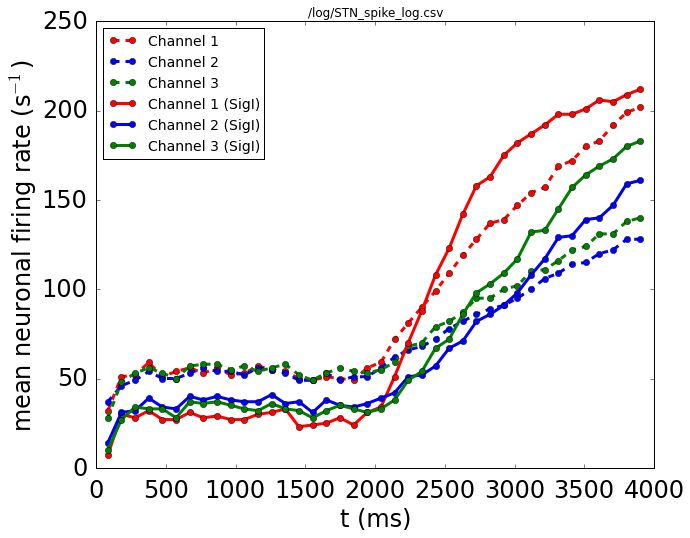

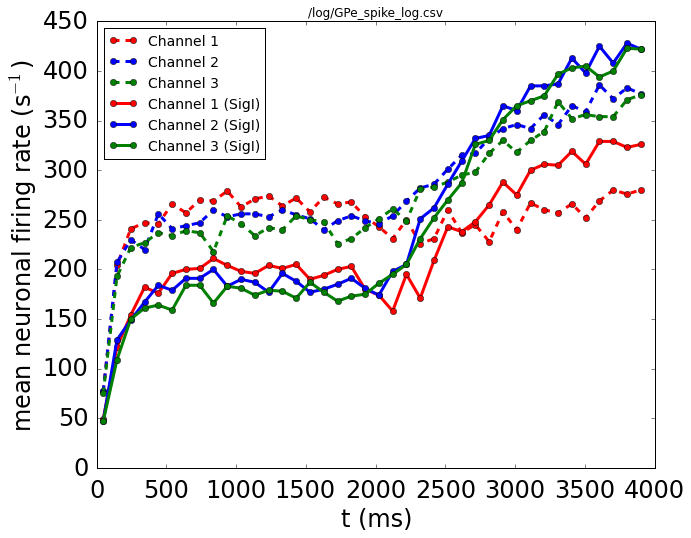

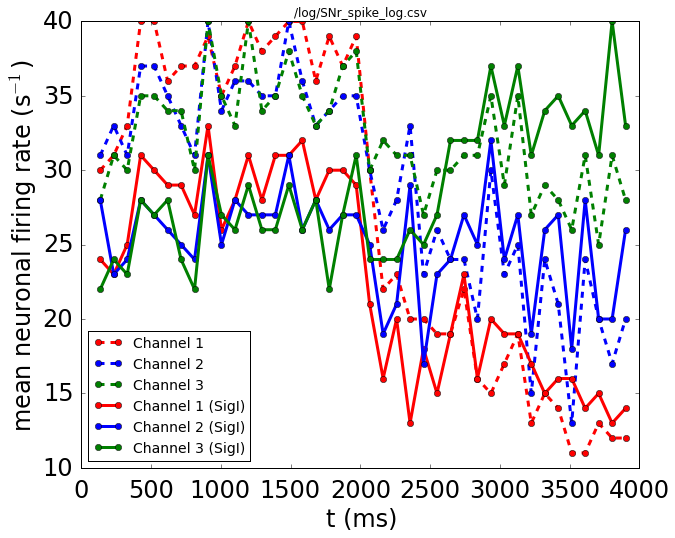

mean ch1 no sigI: 38.1818181818
mean ch1 with sigI: 29.4545454545
decision times: no sigI = 549.2999705 ms (19 1/s) with sigI = 356.1799731 ms (13 1/s)


In [2]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/noSigI'
logdir2 = '/home/seb/tmp/withSigI'

# Import update_bg1_model_xml.py
import sys
sys.path.append("../analysis")
import update_bg1_model_xml as bg1update

print ('THREE CHANNEL MODEL with one channel integrating at a higher rate')

# Where's the source model?
modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_withCI'
# For the bg1 model, set expt to 3 for channel select, 2 for "no input" and 1 for 
# "background input".
# For bg_with_CI_10ch, use expt 1 for channel select, 2 for background input.
# For bg_withCI, use expt 1 for channel select.
expt = 1

# Update the model to ensure that the sigmoidal current is disabled.
disable_sigI = 1
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
# Run the model
import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Update to ENABLE the sigmoidal current, then run again
disable_sigI = 0
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir2` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);


# Now call the visualisation for populations of interest:
logfile = '/log/STN_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/GPe_spike_log.csv'
vis_data (logdir1, logdir2, logfile)

logfile = '/log/SNr_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
ch3_nosigI_ch1lat, ch3_withsigI_ch1lat = compute_decision (logdir1, logdir2, logfile)

FIVE CHANNEL MODEL with first channel integrating faster. First 3 channels shown.


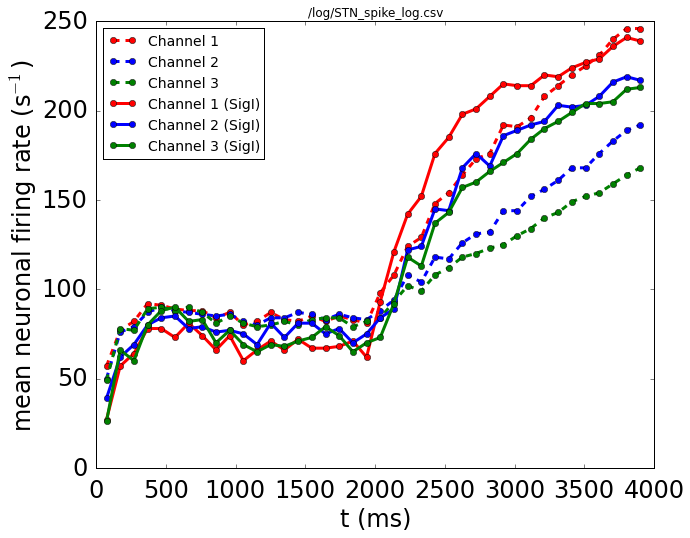

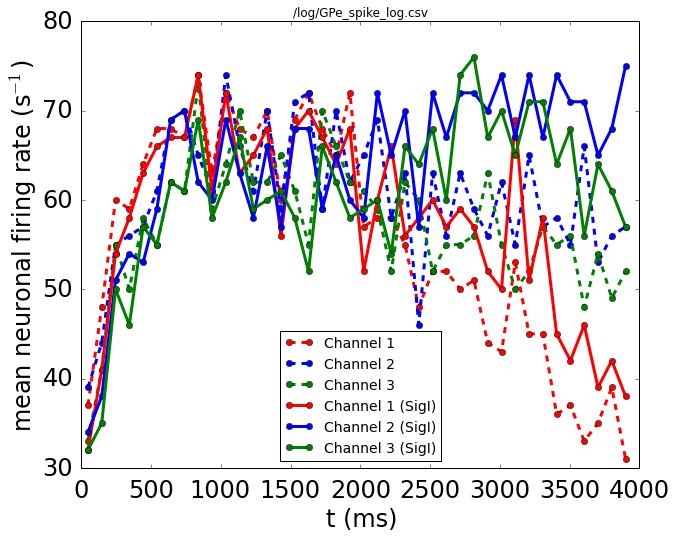

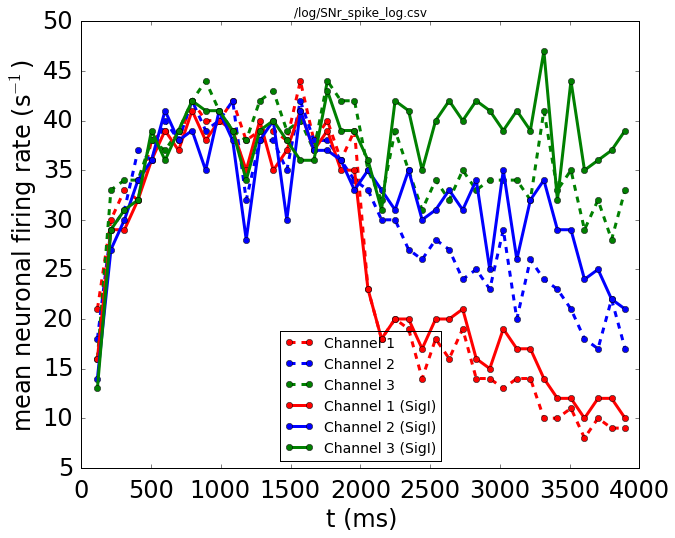

mean ch1 no sigI: 39.3
mean ch1 with sigI: 37.3
decision times: no sigI = 151.642501425 ms (18 1/s) with sigI = 151.642501425 ms (18 1/s)


In [7]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/noSigI'
logdir2 = '/home/seb/tmp/withSigI'

# Import update_bg1_model_xml.py
import sys
sys.path.append("../analysis")
import update_bg1_model_xml as bg1update

print ('FIVE CHANNEL MODEL with first channel integrating faster. First 3 channels shown.')

# Where's the source model?
modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_5ch'
# For bg_with_CI_10ch, use expt 1 for channel select, 2 for background input.
expt = 1

# Update the model to ensure that the sigmoidal current is disabled.
disable_sigI = 1
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
# Run the model
import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Update to ENABLE the sigmoidal current, then run again
disable_sigI = 0
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir2` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Now call the visualisation for populations of interest:
logfile = '/log/STN_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/GPe_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/SNr_spike_log.csv'
vis_data (logdir1, logdir2, logfile)

ch5_nosigI_ch1lat, ch5_withsigI_ch1lat = compute_decision (logdir1, logdir2, logfile)

SEVEN CHANNEL MODEL with first channel integrating faster. First 3 channels shown.


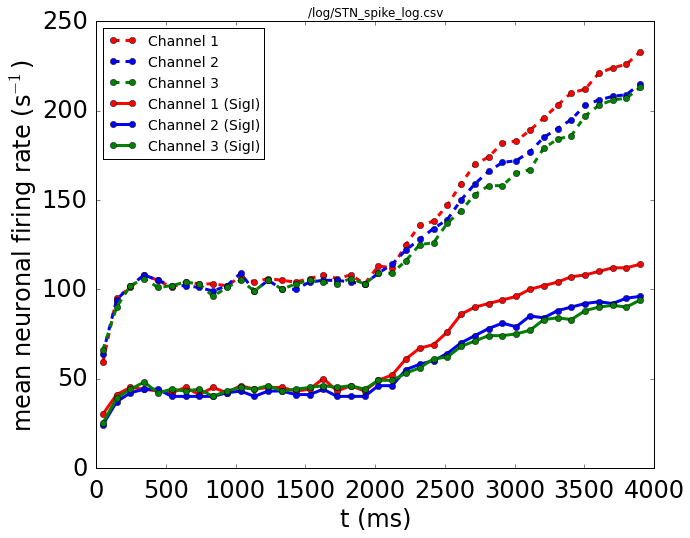

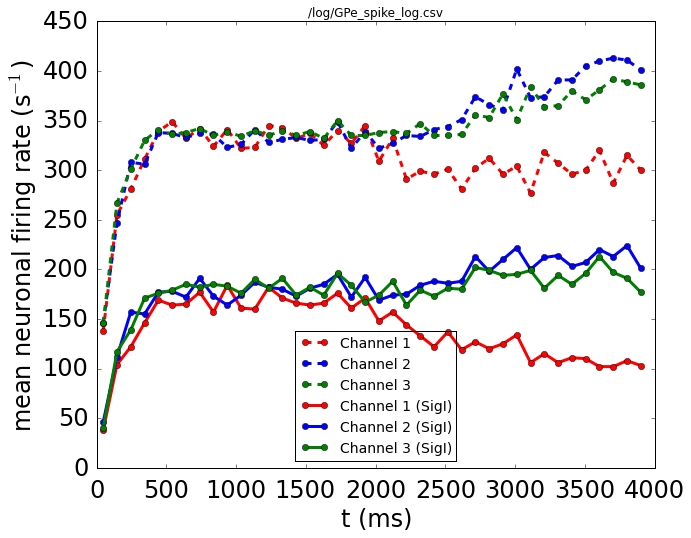

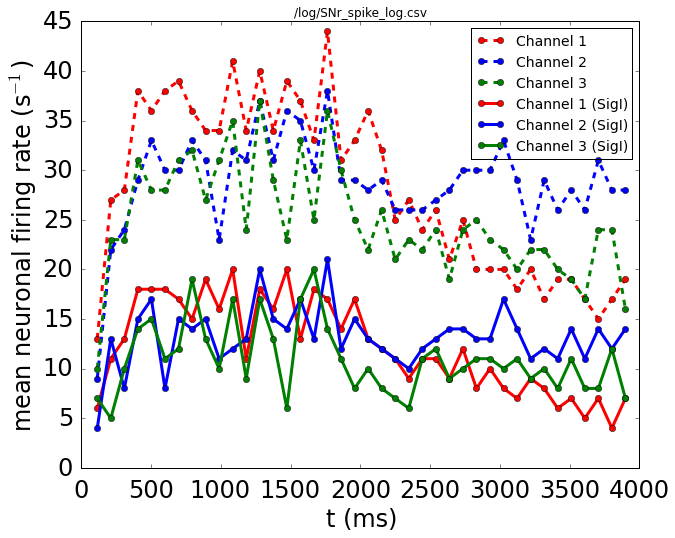

mean ch1 no sigI: 36.6
mean ch1 with sigI: 16.4
decision times: no sigI = 1123.35757663 ms (18 1/s) with sigI = 832.1100695 ms (8 1/s)


In [4]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/noSigI'
logdir2 = '/home/seb/tmp/withSigI'

# Import update_bg1_model_xml.py
import sys
sys.path.append("../analysis")
import update_bg1_model_xml as bg1update

print ('SEVEN CHANNEL MODEL with first channel integrating faster. First 3 channels shown.')

# Where's the source model?
modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_7ch'
# For bg_with_CI_10ch, use expt 1 for channel select, 2 for background input.
expt = 1

# Update the model to ensure that the sigmoidal current is disabled.
disable_sigI = 1
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
# Run the model
import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Update to ENABLE the sigmoidal current, then run again
disable_sigI = 0
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir2` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Now call the visualisation for populations of interest:
logfile = '/log/STN_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/GPe_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/SNr_spike_log.csv'
vis_data (logdir1, logdir2, logfile)

ch7_nosigI_ch1lat, ch7_withsigI_ch1lat = compute_decision (logdir1, logdir2, logfile)

TEN CHANNEL MODEL with first channel integrating faster. First 3 channels shown.


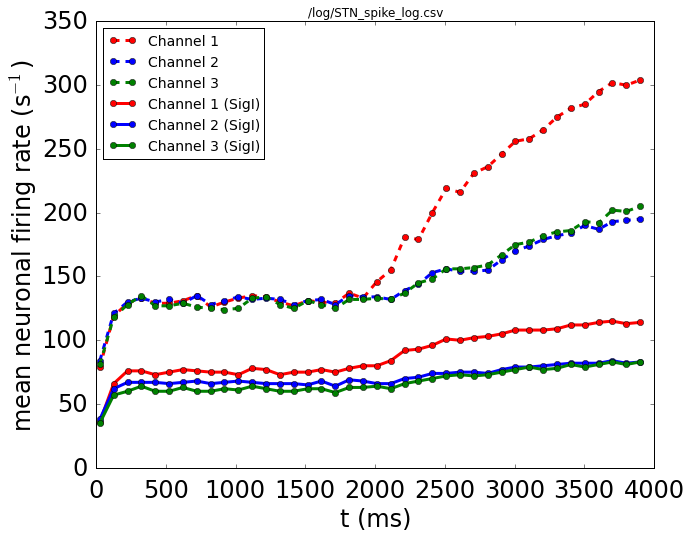

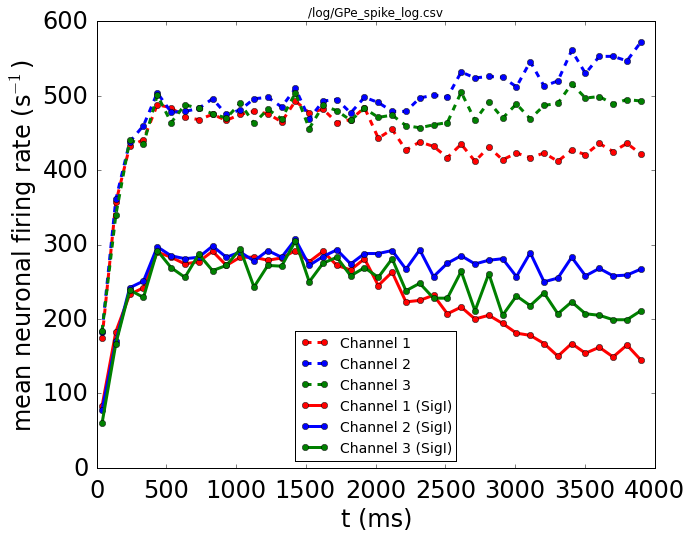

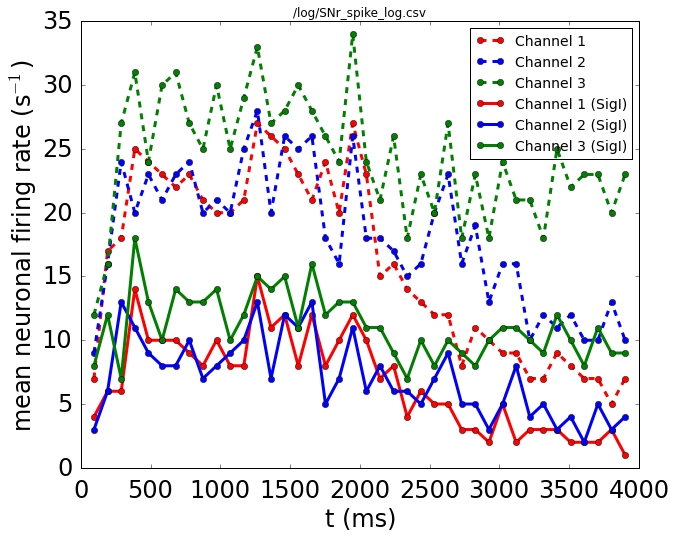

mean ch1 no sigI: 23.4
mean ch1 with sigI: 10.4
decision times: no sigI = 730.710100175 ms (8 1/s) with sigI = 340.190086075 ms (4 1/s)


In [5]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/noSigI'
logdir2 = '/home/seb/tmp/withSigI'

# Import update_bg1_model_xml.py
import sys
sys.path.append("../analysis")
import update_bg1_model_xml as bg1update

print ('TEN CHANNEL MODEL with first channel integrating faster. First 3 channels shown.')

# Where's the source model?
modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_with_CI_10ch'
#modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/bg_withCI'
# For the bg1 model, set expt to 3 for channel select, 2 for "no input" and 1 for 
# "background input".
# For bg_with_CI_10ch, use expt 1 for channel select, 2 for background input.
# For bg_withCI, use expt 1 for channel select. expt 2 to see "no input"
expt = 1

# Update the model to ensure that the sigmoidal current is disabled.
disable_sigI = 1
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
# Run the model
import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Update to ENABLE the sigmoidal current, then run again
disable_sigI = 0
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir2` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Now call the visualisation for populations of interest:
logfile = '/log/STN_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/GPe_spike_log.csv'
vis_data (logdir1, logdir2, logfile)
logfile = '/log/SNr_spike_log.csv'
vis_data (logdir1, logdir2, logfile)

ch10_nosigI_ch1lat, ch10_withsigI_ch1lat = compute_decision (logdir1, logdir2, logfile)

### Plot latencies vs. number of channels

Be sure to run all the code blocks above first!

[  549.2999705    151.64250142  1123.35757663   730.71010017]


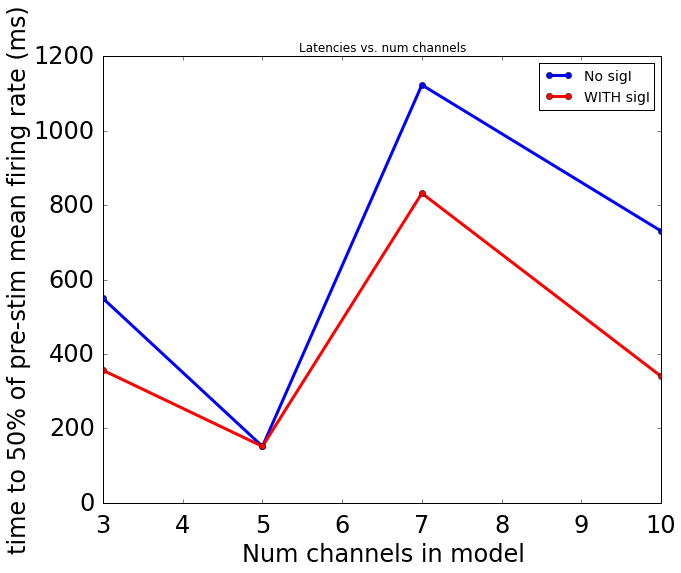

In [8]:
nosigI_ch1latencies = np.array ((ch3_nosigI_ch1lat,   ch5_nosigI_ch1lat,   ch7_nosigI_ch1lat,   ch10_nosigI_ch1lat))
sigI_ch1latencies =   np.array ((ch3_withsigI_ch1lat, ch5_withsigI_ch1lat, ch7_withsigI_ch1lat, ch10_withsigI_ch1lat))

channels = np.array((3,5,7,10))

print nosigI_ch1latencies

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
    
plt.plot (channels,nosigI_ch1latencies, '-', color='b', marker='o', label='No sigI', linewidth=3)
plt.plot (channels,sigI_ch1latencies, '-', color='r', marker='o', label='WITH sigI', linewidth=3)
    
plt.legend(loc='best',fontsize=14)

plt.xlabel('Num channels in model',fontsize=24);
    
from matplotlib import rc
plt.ylabel('time to 50% of pre-stim mean firing rate (ms)',fontsize=24);
plt.tick_params(axis='x', labelsize=24, pad=10)
plt.tick_params(axis='y', labelsize=24, pad=10)
    
plt.title('Latencies vs. num channels')

graphdir = '/home/seb/izhibg/abrg_local/IzhiBG/labbook/'
filename = 'latencies'
plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
plt.show()


### Collect mean spiking rates from Sigmoidal and non-sigmoidal runs.

In the following code/simulation runs, the main difference between sigmoidal and non-sigmoidal input current transfer function in STN is:

For "background input" to striatum, the firing rate in SNr and GPe is about double what we would expect to see in the physiology.

In [59]:
# Update to ENABLE the sigmoidal current, then run again
disable_sigI = 0
bg1update.update_bg1_model_xml (modeldir,disable_sigI)
    
# Run model and then measure spiking rates.
expt = 2 # This is the "No Input" experiment
print '\n\nRunning bg1 model experiment WITH Sigmoidal current but NO inputs (repeat of earlier block)',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [20]: ', r,'spikes/s'

expt = 1 # This is the "Background only" expt
print '\n\nRunning bg1 model experiment WITH Sigmoidal current and background input',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'Steady state (with background input)\' results\n------------------'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [?]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [25]: ', r,'spikes/s'

# Update to DISABLE the sigmoidal current, then run again
disable_sigI = 1
bg1update.update_bg1_model_xml (modeldir,disable_sigI)

# Run model and then measure spiking rates.
expt = 2 # This is the "No Input" experiment
print '\n\nRunning bg1 model experiment WITHOUT Sigmoidal current and NO inputs',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'No input\' results\n------------------'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [5]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [70]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [20]: ', r,'spikes/s'

expt = 1 # This is the "Background only" expt
print '\n\nRunning bg1 model experiment WITHOUT Sigmoidal current and with background input',expt
run_bg1_model (expt)
print 'Done.'

print '\n\'Steady state (with background input)\' results\n------------------'
r = channel_spiking('D1_MSN', d1_spike_thresh, 300, 800, 0, 19)
print 'D1 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('D2_MSN', d2_spike_thresh, 300, 800, 0, 19)
print 'D2 mean rate [60]: ', r,'spikes/s'
r = channel_spiking('STN', stn_spike_thresh, 300, 800, 0, 19)
print 'STN mean rate [?]: ', r,'spikes/s'
r = channel_spiking('GPe', gpe_spike_thresh, 300, 800, 0, 19)
print 'GPe mean rate [?]: ', r,'spikes/s'
r = channel_spiking('SNr', snr_spike_thresh, 300, 800, 0, 19)
print 'SNr mean rate [25]: ', r,'spikes/s'



Running bg1 model experiment WITH Sigmoidal current but NO inputs (repeat of earlier block) 2
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  56.9473684211 spikes/s
SNr mean rate [20]:  22.7368421053 spikes/s


Running bg1 model experiment WITH Sigmoidal current and background input 1
Done.

'Steady state (with background input)' results
------------------
D1 mean rate [60]:  11.5789473684 spikes/s
D2 mean rate [60]:  7.78947368421 spikes/s
STN mean rate [?]:  18.8421052632 spikes/s
GPe mean rate [?]:  129.789473684 spikes/s
SNr mean rate [25]:  21.8947368421 spikes/s


Running bg1 model experiment WITHOUT Sigmoidal current and NO inputs 2
Done.

'No input' results
------------------
STN mean rate [5]:  6.0 spikes/s
GPe mean rate [70]:  56.9473684211 spikes/s
SNr mean rate [20]:  22.7368421053 spikes/s


Running bg1 model experiment WITHOUT Sigmoidal current and with background input 1
Done.

'Steady state (with background input)' re

### 2016-04-26

#### A note on the background input to the bg1 model.

The "Background" spike source contains 600 spike trains. In the experiment "Steady state", the Background input is a spiking input with constant spike rate of 5 (Poisson spike train). The connection probability from the "Background" spike source to the D1 MSN, D2 MSN and STN populations is 0.1. That means we expect one neuron in STN (or D1 or D2) to receive connections from about 60 spike trains. Each of those spikes at 5 s$^{-1}$, so the overal synaptic event rate at each neuron (due to background spiking) is approx. 300 s$^{-1}$. A look at the synaptic currents on single neurons in D1 MSN bear this analysis out.

I'm going to add information to spiking rates in a previous field (see entry for 2015-10-02). It does seem that firing rates for GPe shouldn't be exceeding 100 s$^{-1}$ or so, and so the fact that the sigmoidal current holds that GPe firing rate down is a good argument that its inclusion in the model is warranted.

### 2016-04-27

Kevin reminded me that there is a link between the sigmoidal current transfer function and the MSPRT - the MSPRT wouldn't map onto the BG without a sigmoidal transfer fn in STN. See Bogacz & Gurney - "The Basal Ganglia and Cortex Implement Optimal Decision
Making Between Alternative Actions" 2007. This is a much deeper reason for requiring the sigmoidal relationship. However, I'm not able to detect any clear difference between the two as far as selection goes, even for low inputs to the channel select experiment. The only clear differentiator seems to be a slightly leading activiation of STN neurons.

### 2016-05-04

I created a 10 channel version of the spiking bg  with 200 neurons per population, 20 neurons per channel. I created 10 "Cortical integrator" channels and aim to see how the selection time for this model compares with the 2/3 channels of the bg1 model. I'll do this in the mean firing rate visualiser above, or perhaps I will have to create a new one for many-channeled models?

#### 2016-05-10

I did it in the visualiser code above (heading "Mean Firing Rate Visualiser). With three channels, I can see an earlier selection using the criterion "time to 50% of pre-stimulus mean firing rate". With ten channels, there's no evidence of earlier selection with the sigmoidal current.

Differences between the three channel (bg_withCI) and ten channel (bg_with_CI_10ch) models:
* With ten channels, GPe->GPe connection weight is 2.222 cf. 10 for three channels. This on account of the additional inter-connects with a 200 neuron, 10 channel model. Each channel in the 3 ch model receives connectivity from 2 other channels. In the 10 channel model, each channel receives connectivity from 9 other channels. So, the  previous weight (10) needs to be divided by 9/2 giving 2.22222.
* With 10 channels, the STN->GPe innervation (alltoall) is 20/6 times that in the 3 channel, 60 neuron model, so reduce the weight of this connection from 0.235 to 3/10 * 0.235 = 0.0705
* Similarly for STN->SNr reduce 0.1 to 3/10 * 0.1 = 0.03

#### 2016-05-11

Adding a 5 channel system now.

* GPe->GPe connection weight now 10 / 4/2 = 5
* STN->GPe connection weight is 0.235 * 3/5 = 0.141
* STN->SNr connection weight is 0.1 * 3/5 = 0.06

Also a 7 channel system

* GPe->GPe connection weight now 10 / 6/2 = 3.333
* STN->GPe connection weight is 0.235 * 3/7 = 0.10071
* STN->SNr connection weight is 0.1 * 3/7 = 0.04286

### 2016-05-13

I've decided to draw k, I0 and Imax from normal distributions, giving me values which match a larger group of experimental data, including that from Hallworth et al 2003 and Wilson et al 2004, as referenced by the Bogacz & Gurney paper.
